In [1]:
from tensorflow.keras.models import load_model
from functions import PredictGenerator,l2_distance_np,top_k,loop_distance,\
                        MAP,generate_feature,GridSearch,NW_PredictGenerator
import pickle
from albumentations import ShiftScaleRotate,Cutout,RandomContrast,RandomBrightness,Compose
from utility.albumentations_helper import create_transform
import time
import tensorflow as tf
import numpy as np
from functools import partial
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [28]:
## change ##
color = False
distance = l2_distance_np
FFA_size = 4
TTA_NW = 4
factor = (1/0.276-1)

In [3]:
if color:
    with open('/home/will/Desktop/kaggle/Whale/train_df_color.pkl', 'rb') as f:
        Ids_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_train_color.pkl', 'rb') as f:
        newWhale_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/val_df_color.pkl', 'rb') as f:
        Ids_val = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_val_color.pkl', 'rb') as f:
        newWhale_val = pickle.load(f)
else:
    with open('/home/will/Desktop/kaggle/Whale/train_df.pkl', 'rb') as f:
        Ids_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_train.pkl', 'rb') as f:
        newWhale_train = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/val_df.pkl', 'rb') as f:
        Ids_val = pickle.load(f)
    with open('/home/will/Desktop/kaggle/Whale/new_whale_val.pkl', 'rb') as f:
        newWhale_val = pickle.load(f)

In [4]:
aug = Compose([RandomContrast(p=0.2),RandomBrightness(p=0.2),
                ShiftScaleRotate(shift_limit=0.03,rotate_limit=15,scale_limit=0.02,p=1)])
transform = create_transform(aug)    

### predict New Whale

In [26]:
NW_model = load_model('Models/NewWhale.h5')

In [30]:
Imgs = sum(Ids_val.Imgs.tolist(),[])
class_num = len(Imgs)
NW_num = int(len(Imgs)//factor)
Imgs = Imgs + newWhale_val[:NW_num]

In [31]:
gen = NW_PredictGenerator(Imgs,transform)

In [32]:
p_NW_list = [NW_model.predict_generator(gen,workers=2,use_multiprocessing=True).flatten() for _ in range(TTA_NW)]

In [33]:
[roc_auc_score(np.arange(len(Imgs))>class_num,np.sum(np.stack(p_NW_list,1)[:,:i],1)) for i in range(1,5)]

[0.7465333302873851,
 0.7551844575420213,
 0.7558018966103673,
 0.7576085245934928]

In [34]:
p_NW = np.sum(np.stack(p_NW_list,1),1)

In [35]:
np.save('p_NW.npy',p_NW)

### Existing Whale quantile determination

In [ ]:
feature_model = load_model('Models/feature_model_DenseNet_Triplet2.h5')

In [8]:
# aggFuns = [partial(np.quantile,q=pct,axis=(1,2)) for pct in [0.1,0.25,0.5]] + [partial(np.mean,axis=(1,2))]
# FFA_sizes = [4,8]
aggFuns = [partial(np.quantile,q=pct,axis=(1,2)) for pct in np.linspace(0,0.2,21)]
FFA1_sizes = [4]
FFA2_sizes = [4]

In [9]:
gs_dict = GridSearch(aggFuns,FFA1_sizes,FFA2_sizes,Ids_train,Ids_val,\
                     transform,color,feature_model,distance,k=5)

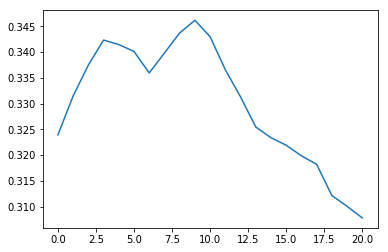

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot([gs_dict[(4,4),pct] for pct in np.linspace(0,0.2,21)])

In [11]:
gs_dict

{((4, 4), 0.0): 0.3239332096474954,
 ((4, 4), 0.01): 0.3314780457637601,
 ((4, 4), 0.02): 0.3374768089053803,
 ((4, 4), 0.03): 0.34233147804576375,
 ((4, 4), 0.04): 0.3414656771799629,
 ((4, 4), 0.05): 0.3401205936920223,
 ((4, 4), 0.06): 0.33594619666048237,
 ((4, 4), 0.07): 0.3398268398268398,
 ((4, 4), 0.08): 0.34370748299319726,
 ((4, 4), 0.09): 0.34618119975262834,
 ((4, 4), 0.1): 0.3429808286951144,
 ((4, 4), 0.11): 0.33658008658008653,
 ((4, 4), 0.12): 0.3313079777365492,
 ((4, 4), 0.13): 0.32546382189239337,
 ((4, 4), 0.14): 0.3233766233766234,
 ((4, 4), 0.15): 0.3219233147804576,
 ((4, 4), 0.16): 0.31986703772418057,
 ((4, 4), 0.17): 0.318212739641311,
 ((4, 4), 0.18): 0.312152133580705,
 ((4, 4), 0.19): 0.31006493506493504,
 ((4, 4), 0.2): 0.3078076685219542}

### Combine New and Existing Whale

In [15]:
pct = 0.09

In [6]:
p_NW = np.load('p_NW.npy')

In [7]:
feature_model = load_model('Models/feature_model_DenseNet_Triplet2.h5')

In [12]:
Imgs = sum(Ids_val.Imgs.tolist(),[])
class_num = len(Imgs)
NW_num = int(len(Imgs)//factor)
tot_num = class_num + NW_num
Imgs = Imgs + newWhale_val[:NW_num]
Imgs = [[img] for img in Imgs]

In [13]:
feature_train = generate_feature(Ids_train,transform,FFA_size,color,feature_model)
feature_val = generate_feature(Imgs,transform,FFA_size,color,feature_model)

In [16]:
predicts = loop_distance(feature_train,feature_val,distance,partial(np.quantile,q=pct,axis=(1,2)))

In [17]:
repeat_ids = sum([[i]*len(j) for i,j in zip(Ids_val.Id.tolist(),Ids_val.Imgs.tolist())],[])
mapping_dict = dict(zip(Ids_train.Id.values,Ids_train.index.values))
labels = [mapping_dict[id] for id in repeat_ids]
labels = labels + [-1]*NW_num

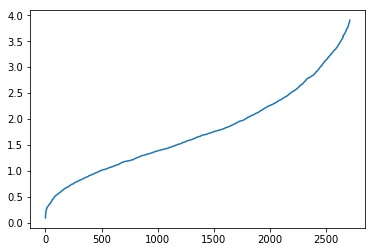

In [18]:
plt.plot(np.sort(p_NW))

In [46]:
num_bins = 2
tot_num = predicts.shape[0]
bins = np.quantile(p_NW,np.arange(num_bins+1)/num_bins)
bins[0] = -1
bins[-1] = 10
inds = num_bins - np.digitize(p_NW,bins)
print(np.unique(inds),np.bincount(inds))

[0 1] [1405 1405]


In [44]:
predicts_nw = np.insert(predicts.flatten(),inds + np.arange(tot_num)*5,-1).reshape(tot_num,6)

In [42]:
# num_bins = 5
MAP(np.array(labels),predicts_nw[:,:5])

0.39698695136417556

In [38]:
# num_bins = 4
MAP(np.array(labels),predicts_nw[:,:5])

0.4069691577698696

In [45]:
# num_bins = 3
MAP(np.array(labels),predicts_nw[:,:5])

0.41782325029655987

In [47]:
# num_bins = 2
MAP(np.array(labels),predicts_nw[:,:5])

0.41782325029655987

In [39]:
MAP(np.array(labels),np.concatenate([-np.ones((tot_num,1)),predicts[:,:4]],-1))

0.39902135231316727